In [73]:
# importing packages
import tensorflow as tf
from tensorflow.keras import models,regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io 
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.set_option('display.max_colwidth', None)

# EDA

In [2]:
subfolder_list = ['fold_0', 'fold_1', 'fold_2']
diagnosis_list = ['all', 'hem']

total_all = 0
total_hem = 0
for subfolder in subfolder_list:
    for diagnosis in diagnosis_list:
        image_number = os.listdir(os.path.join("../input/leukemia-classification/C-NMC_Leukemia", "training_data",subfolder, diagnosis))
        print(f"Number of images in {subfolder} - {diagnosis} folder = {len(image_number)}")    
        if diagnosis == 'all':
            total_all += len(image_number)
        else:
            total_hem += len(image_number)

print(f"Total all images = {total_all}")
print(f"Total hem images = {total_hem}")

Number of images in fold_0 - all folder = 2397
Number of images in fold_0 - hem folder = 1130
Number of images in fold_1 - all folder = 2418
Number of images in fold_1 - hem folder = 1163
Number of images in fold_2 - all folder = 2457
Number of images in fold_2 - hem folder = 1096
Total all images = 7272
Total hem images = 3389


# Data pre-processing

In [3]:
#Put all training data into one dataframe with labels

filepaths = []
labels = []

image_paths = []
for subfolder in subfolder_list:
    for diagnosis in diagnosis_list:
        folder_path = os.listdir(os.path.join("../input/leukemia-classification/C-NMC_Leukemia", "training_data",subfolder, diagnosis))
        for folder_ in folder_path:
            image_paths.append(os.path.join("../input/leukemia-classification/C-NMC_Leukemia", "training_data",subfolder, diagnosis, folder_))
            labels.append(diagnosis)

df = pd.DataFrame({"image_path":image_paths, "label": labels})
df

,image_path,label
0,../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/UID_28_5_3_all.bmp,all
1,../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/UID_45_24_5_all.bmp,all
2,../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/UID_45_7_1_all.bmp,all
3,../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/UID_52_10_5_all.bmp,all
4,../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/UID_52_21_7_all.bmp,all
...,...,...
10656,../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem/UID_H23_19_8_hem.bmp,hem
10657,../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem/UID_H48_10_3_hem.bmp,hem
10658,../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem/UID_H2_33_2_hem.bmp,hem
10659,../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem/UID_H2_38_3_hem.bmp,hem


In [4]:
df.info()
df['label'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10661 entries, 0 to 10660
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10661 non-null  object
 1   label       10661 non-null  object
dtypes: object(2)
memory usage: 166.7+ KB


array(['all', 'hem'], dtype=object)

In [5]:
# set random seed
RANDOM_SEED = 123

#create train and val dataset
train_df, val_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = RANDOM_SEED, stratify = df["label"])

In [6]:
# importing images from dataframe

img_size = (300, 300)
channels = 3 
colour = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 32

train_generator = ImageDataGenerator(preprocessing_function= (lambda x:x), horizontal_flip= True, vertical_flip = True)

train_data = train_generator.flow_from_dataframe(train_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                        color_mode= colour, shuffle= True, batch_size= batch_size)

val_data = train_generator.flow_from_dataframe(val_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                        color_mode= colour, shuffle= True, batch_size= batch_size)

Found 8528 validated image filenames belonging to 2 classes.
Found 2133 validated image filenames belonging to 2 classes.


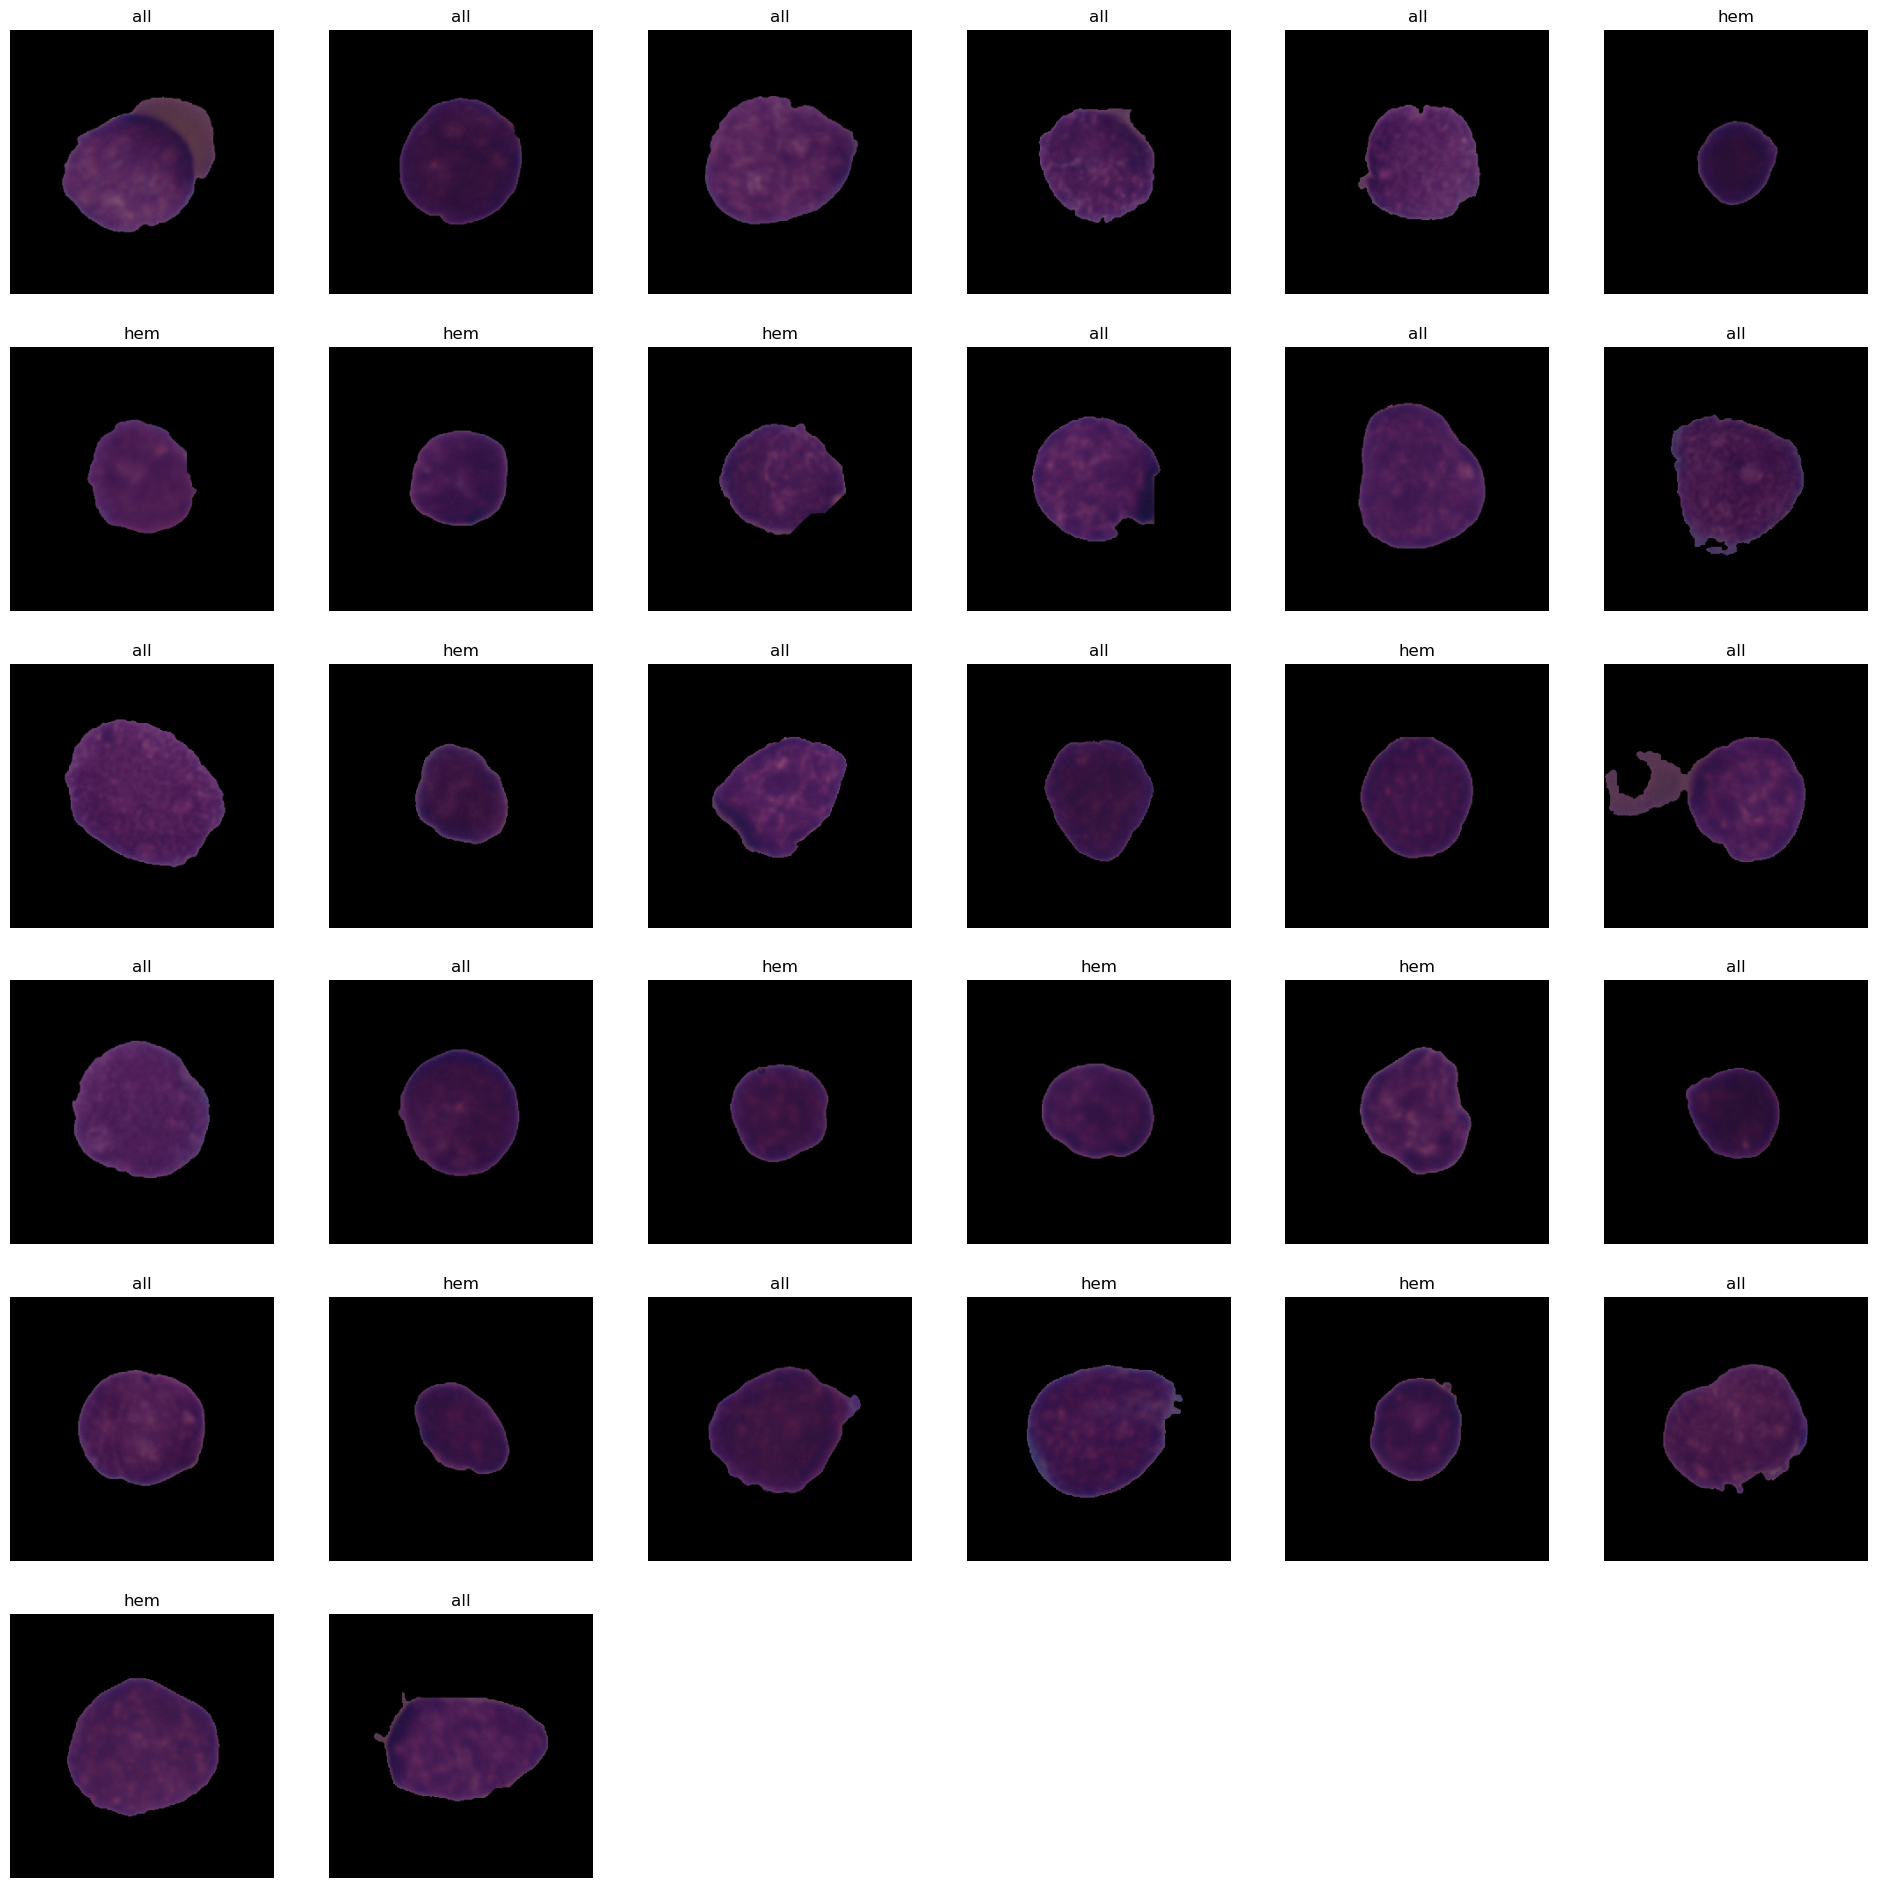

In [7]:
# image visualisation

cat = list(train_data.class_indices.keys())
images, labels = train_data.next()

plt.figure(figsize=(24,24))
for i in range(len(labels)):
    plt.subplot(6, 6, i+1)
    image = (images[i] / 255)  
    plt.imshow(image)  
    plt.title(cat[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

# Modelling

In [9]:
base_model = EfficientNetB3(include_top= False\
                            ,weights= "imagenet"\
                            ,input_shape= img_shape\
                            ,pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.999, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.0155), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.0055), activation= 'relu'),
    Dropout(rate= 0.40, seed= RANDOM_SEED),
    Dense(len(cat), activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non-trainable params: 90,375
_____________________________________

# Training Model

In [10]:
#set training parameters
epochs = 60
patience = 10
monitor = "val_loss"
model_name = f"model_ENB3_e{epochs}_p{patience}"

#early stopping
es = EarlyStopping(monitor, patience, epochs, restore_best_weights=True)

#fit
history = model.fit(train_data, epochs= epochs, verbose= 1, callbacks= [es],
                    validation_data= val_data, validation_steps= None, shuffle= False)

Epoch 1/60


2023-06-03 23:06:56.746615: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


267/267 [==============================] - 362s 1s/step - loss: 4.5361 - accuracy: 0.8392 - val_loss: 3.1984 - val_accuracy: 0.7267
Epoch 2/60
267/267 [==============================] - 261s 977ms/step - loss: 1.8953 - accuracy: 0.9009 - val_loss: 1.3288 - val_accuracy: 0.9109
Epoch 3/60
267/267 [==============================] - 262s 980ms/step - loss: 0.9980 - accuracy: 0.9220 - val_loss: 0.9443 - val_accuracy: 0.8345
Epoch 4/60
267/267 [==============================] - 269s 1s/step - loss: 0.5742 - accuracy: 0.9359 - val_loss: 0.6768 - val_accuracy: 0.8542
Epoch 5/60
267/267 [==============================] - 261s 979ms/step - loss: 0.3827 - accuracy: 0.9421 - val_loss: 0.3236 - val_accuracy: 0.9541
Epoch 6/60
267/267 [==============================] - 262s 979ms/step - loss: 0.2850 - accuracy: 0.9505 - val_loss: 0.2969 - val_accuracy: 0.9306
Epoch 7/60
267/267 [==============================] - 262s 980ms/step - loss: 0.2372 - accuracy: 0.9556 - val_loss: 0.2419 - val_accuracy: 0.

# Save Model and History

In [77]:
# model_path = os.path.join("/kaggle/working", model_name + "_2")
# model.save(model_path)

# filename = '/kaggle/working/leu_model_1.pkl'
# pickle.dump(model, open(filename, 'wb'))

# history_file = '/kaggle/working/history.pkl'
# pickle.dump(history, open(history_file, 'wb'))

# Training curve

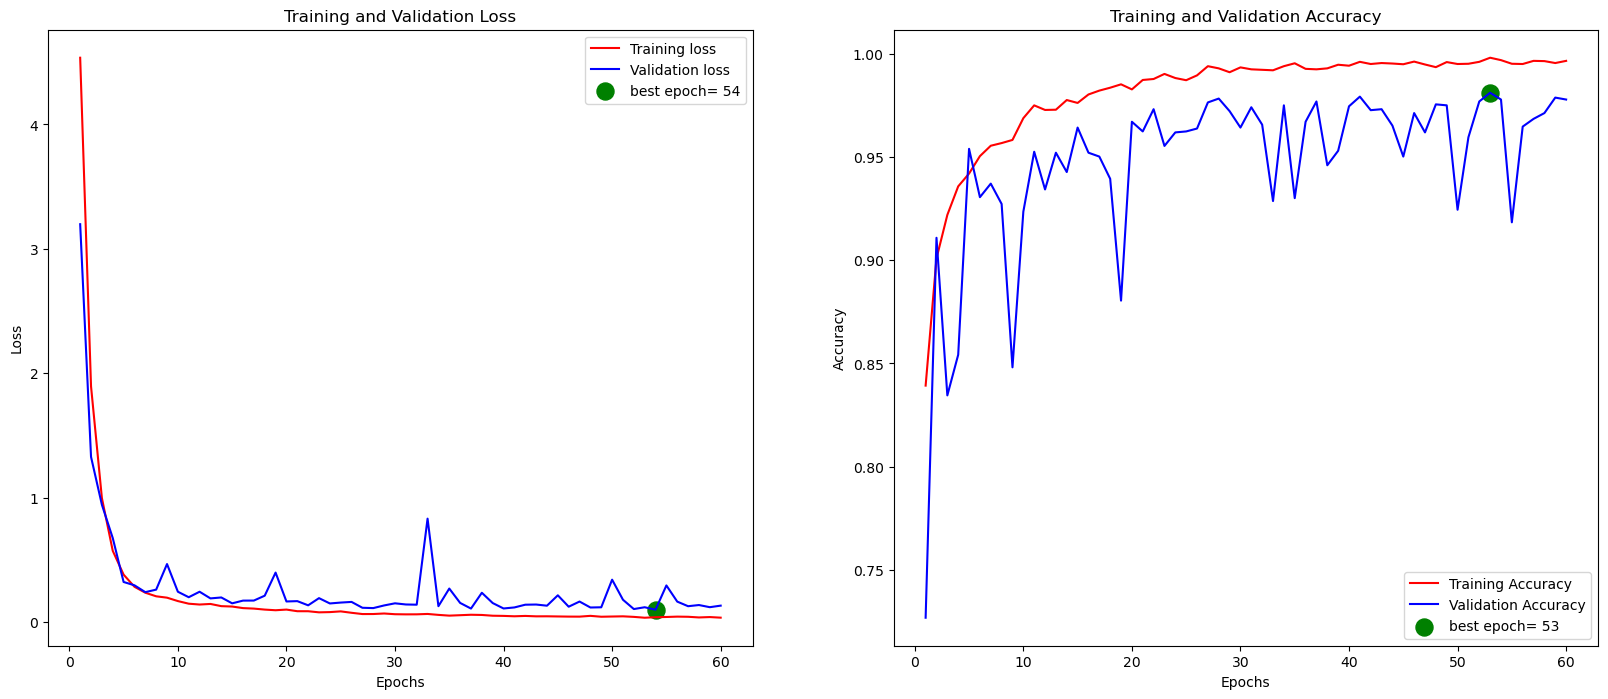

In [30]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_loss_lowest_index = np.argmin(val_loss)
val_loss_lowest = val_loss[val_loss_lowest_index]
val_acc_best_index = np.argmax(val_acc)
val_acc_best = val_acc[val_acc_best_index]
epochs_list = [i+1 for i in range(len(train_acc))]

val_loss_label = f'best epoch= {str(val_loss_lowest_index + 1)}'
val_acc_label = f'best epoch= {str(val_acc_best_index + 1)}'

plt.figure(figsize= (20, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss, color = 'r', label= 'Training loss')
plt.plot(epochs_list, val_loss, color = 'b', label= 'Validation loss')
plt.scatter(val_loss_lowest_index + 1, val_loss_lowest, s= 150, color = 'g', label= val_loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_acc, color = 'r', label= 'Training Accuracy')
plt.plot(epochs_list, val_acc, color = 'b', label= 'Validation Accuracy')
plt.scatter(val_acc_best_index + 1 , val_acc_best, s= 150, color = 'g', label= val_acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Importing test data

In [31]:
test_label_path = os.path.join("/kaggle/input/leukemia-classification/C-NMC_Leukemia", "validation_data", "C-NMC_test_prelim_phase_data_labels.csv")

df2 = pd.read_csv(test_label_path)
df2["image_path"] = df2['new_names'].apply(lambda x: "/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/" + x)
df2["new_label"] = df2["labels"].apply(lambda x: "hem" if x == 0 else "all")
test_df = df2.drop(columns = ["Patient_ID", "new_names", "labels"])
test_df

,image_path,new_label
0,/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1.bmp,all
1,/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/2.bmp,all
2,/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/3.bmp,all
3,/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/4.bmp,hem
4,/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/5.bmp,all
...,...,...
1862,/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1863.bmp,all
1863,/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1864.bmp,all
1864,/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1865.bmp,hem
1865,/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1866.bmp,all


In [32]:
test_generator = ImageDataGenerator(preprocessing_function= (lambda x:x))
test_data = test_generator.flow_from_dataframe(test_df, x_col= 'image_path', y_col= 'new_label', target_size= img_size, class_mode= 'categorical',
                                        color_mode= colour, shuffle= False, batch_size= batch_size)

Found 1867 validated image filenames belonging to 2 classes.


# Testing Model

In [33]:
predictions = model.predict(test_data)

test_score = model.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

59/59 [==============================] - 14s 230ms/step - loss: 0.7840 - accuracy: 0.8356
Test Loss:  0.7839858531951904
Test Accuracy:  0.8355650901794434


# Classification Report

In [35]:
pred_labels = np.argmax(predictions, axis = 1)
df3 = pd.DataFrame(pred_labels, columns = ["pred_label"])

pred_label_df = df3['pred_label'].apply(lambda x: "all" if x == 0 else "hem")
all_pred = pd.concat([test_df, pred_label_df], axis = 1)
incorrect_pred = all_pred[all_pred["new_label"] != all_pred["pred_label"]]

In [58]:
print(classification_report(test_data.classes, pred_labels, target_names = test_data.class_indices))

              precision    recall  f1-score   support

         all       0.82      0.96      0.88      1219
         hem       0.89      0.60      0.72       648

    accuracy                           0.84      1867
   macro avg       0.85      0.78      0.80      1867
weighted avg       0.84      0.84      0.83      1867



# Confusion Matrix

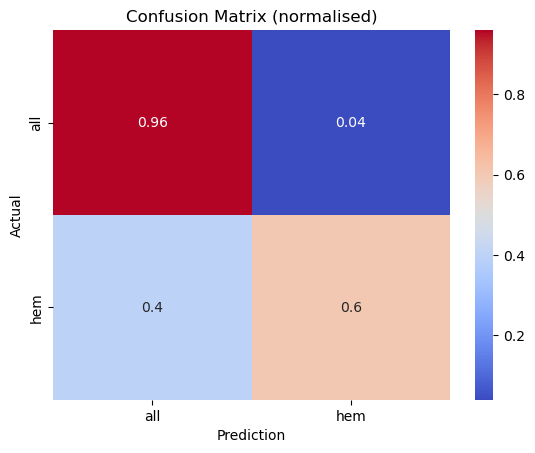

In [81]:
test_cat = test_data.class_indices
classes = list(test_cat.keys())

# Confusion matrix
cm = confusion_matrix(test_data.classes, pred_labels,normalize='true')
s = sns.heatmap(cm,xticklabels=classes, yticklabels=classes, cmap="coolwarm", annot = True)
s.set(ylabel="Actual", xlabel="Prediction", title="Confusion Matrix (normalised)");

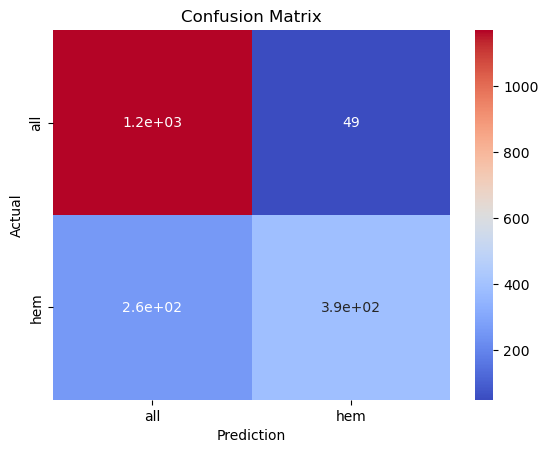

In [82]:
cm1 = confusion_matrix(test_data.classes, pred_labels)
s1 = sns.heatmap(cm1,xticklabels=classes, yticklabels=classes, cmap="coolwarm", annot = True)
s1.set(ylabel="Actual", xlabel="Prediction", title="Confusion Matrix");